In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "theroyakash" # username from the json file
os.environ['KAGGLE_KEY'] = "0c952bf9d48e02510ca5a7b61823f49b" # key from the json file
!kaggle datasets download -d theroyakash/akhcrnetv1dataprivate # api copied from kaggle

100% 186M/187M [00:07<00:00, 32.8MB/s]
100% 187M/187M [00:07<00:00, 27.4MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile('akhcrnetv1dataprivate.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


TRAINING_DIR = "/content/Images"
batch_size = 256

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=False,
    validation_split=0.28) # set validation split

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(32,32),
    color_mode='grayscale',
	class_mode='categorical',
    batch_size = batch_size,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, # same directory as training data
    target_size=(32,32),
    color_mode='grayscale',
	class_mode='categorical',
    batch_size = batch_size,
    subset='validation') # set as validation data

Found 118394 images belonging to 84 classes.
Found 45983 images belonging to 84 classes.


In [ ]:
class AKHCRNetV2():
    
    def make_model(self):
        
        input_shape = self.input_shape
        input_layer = Input(input_shape)
        conv2D_1 = Conv2D(32, (5, 5), activation='relu', padding='same', name='conv2D_1')(input_layer)
        conv2D_2 = Conv2D(32, (5, 5), padding='same', name='conv2D_2')(conv2D_1)
        batchnorm_1 = BatchNormalization(name='first_batchNorm_layer')(conv2D_2)
        activation1 = Activation('relu')(batchnorm_1)
        
        maxpool_1 = MaxPooling2D(pool_size=(2,2))(batchnorm_1)
        
        first_branch_0_conv2D_1 = Conv2D(128, (1, 1), activation='relu', padding='same', name='first_branch_0_conv2D_1')(maxpool_1)
        first_branch_0_conv2D_2 = Conv2D(128, (5, 5), activation='relu', padding='same', name='first_branch_0_conv2D_2')(first_branch_0_conv2D_1)
        
        first_branch_1_conv2D_1 = Conv2D(128, (1, 1),activation='relu',padding='same', name='first_branch_1_conv2D_1')(maxpool_1)
        first_branch_1_conv2D_2 = Conv2D(128, (3, 3),activation='relu',padding='same', name='first_branch_1_conv2D_2')(first_branch_1_conv2D_1)
        
        first_branch_2_conv2D = Conv2D(128, (1, 1),activation='relu',padding='same', name='first_branch_2_conv2D')(maxpool_1)
        
        first_branch_3_MaxPool_1 = MaxPooling2D((3,3), strides=(1,1), padding='same', name='first_branch_3_MaxPool_1')(maxpool_1)
        first_branch_3_Convolution = Conv2D(64, (1,1), padding='same', activation='relu', name='first_branch_3_Convolution')(first_branch_3_MaxPool_1)
                
        concatened_first_branch = Concatenate()([first_branch_0_conv2D_2, first_branch_1_conv2D_2, first_branch_2_conv2D, first_branch_3_Convolution])
        concatenation_activation = Activation('relu')(concatened_first_branch)

        conv2D_3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2D_3')(concatenation_activation)
        maxpool_2 = MaxPooling2D(pool_size=(2,2))(conv2D_3)
        conv2D_4 = Conv2D(256, (3, 3), padding='same', name='conv2D_4')(maxpool_2)
        batchnorm_2 = BatchNormalization(name='second_batchNorm_layer')(conv2D_4)
        activation2 = Activation('relu')(batchnorm_2)

        conv2D_5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2D_5')(activation2)
        maxpool_3 = MaxPooling2D(pool_size=(2,2))(conv2D_5)
        conv2D_6 = Conv2D(512, (3, 3), padding='same', name='conv2D_6')(maxpool_3)
        batchnorm_3 = BatchNormalization(name='third_batchNorm_layer')(conv2D_6)
        activation3 = Activation('relu')(batchnorm_3)
        maxpool_4 = MaxPooling2D(pool_size=(2,2))(activation3)
        
        flattened_before_dense = Flatten()(maxpool_4)
        dense1 = Dense(1024, activation='relu', name='firstDenseLayer', kernel_regularizer= keras.regularizers.l2(0.001))(flattened_before_dense)
        dense2 = Dense(512, activation='relu', name='SecondDenseLayer', kernel_regularizer= keras.regularizers.l2(0.001))(dense1)
        dropout1 = Dropout(0.5, name='FirstDropOutLayer')(dense2)
        dense3 = Dense(256, activation='relu', name='ThirdDenseLayer', kernel_regularizer= keras.regularizers.l2(0.001))(dropout1)
        
        dense4 = Dense(128, activation='relu', name='FourthDenseLayer')(dense3)

        prediction_branch = Dense(self.output,activation='softmax', name='FinalSoftmaxLayer')(dense4)

        model = Model(inputs=input_layer, outputs=prediction_branch)
        
        
        return model
    
    def show_graph(self):
        return model.summary()
    
    def __init__(self, input_shape, output):
        self.input_shape = input_shape
        self.output = output

In [ ]:
architecture = AKHCRNetV2(input_shape= (32, 32, 1), output=84)

In [ ]:
model = architecture.make_model()

In [ ]:
architecture.show_graph()

In [ ]:
learning_rate = 0.001
epochs = 20
batch_size = 256

In [ ]:
model.compile(loss='categorical_crossentropy', 
                metrics=['accuracy'],
                optimizer=Adam(learning_rate=0.001))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2D_1 (Conv2D)               (None, 32, 32, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2D_2 (Conv2D)               (None, 32, 32, 32)   25632       conv2D_1[0][0]                   
__________________________________________________________________________________________________
first_batchNorm_layer (BatchNor (None, 32, 32, 32)   128         conv2D_2[0][0]                   
______________________________________________________________________________________________

In [ ]:
len(model.layers)

32

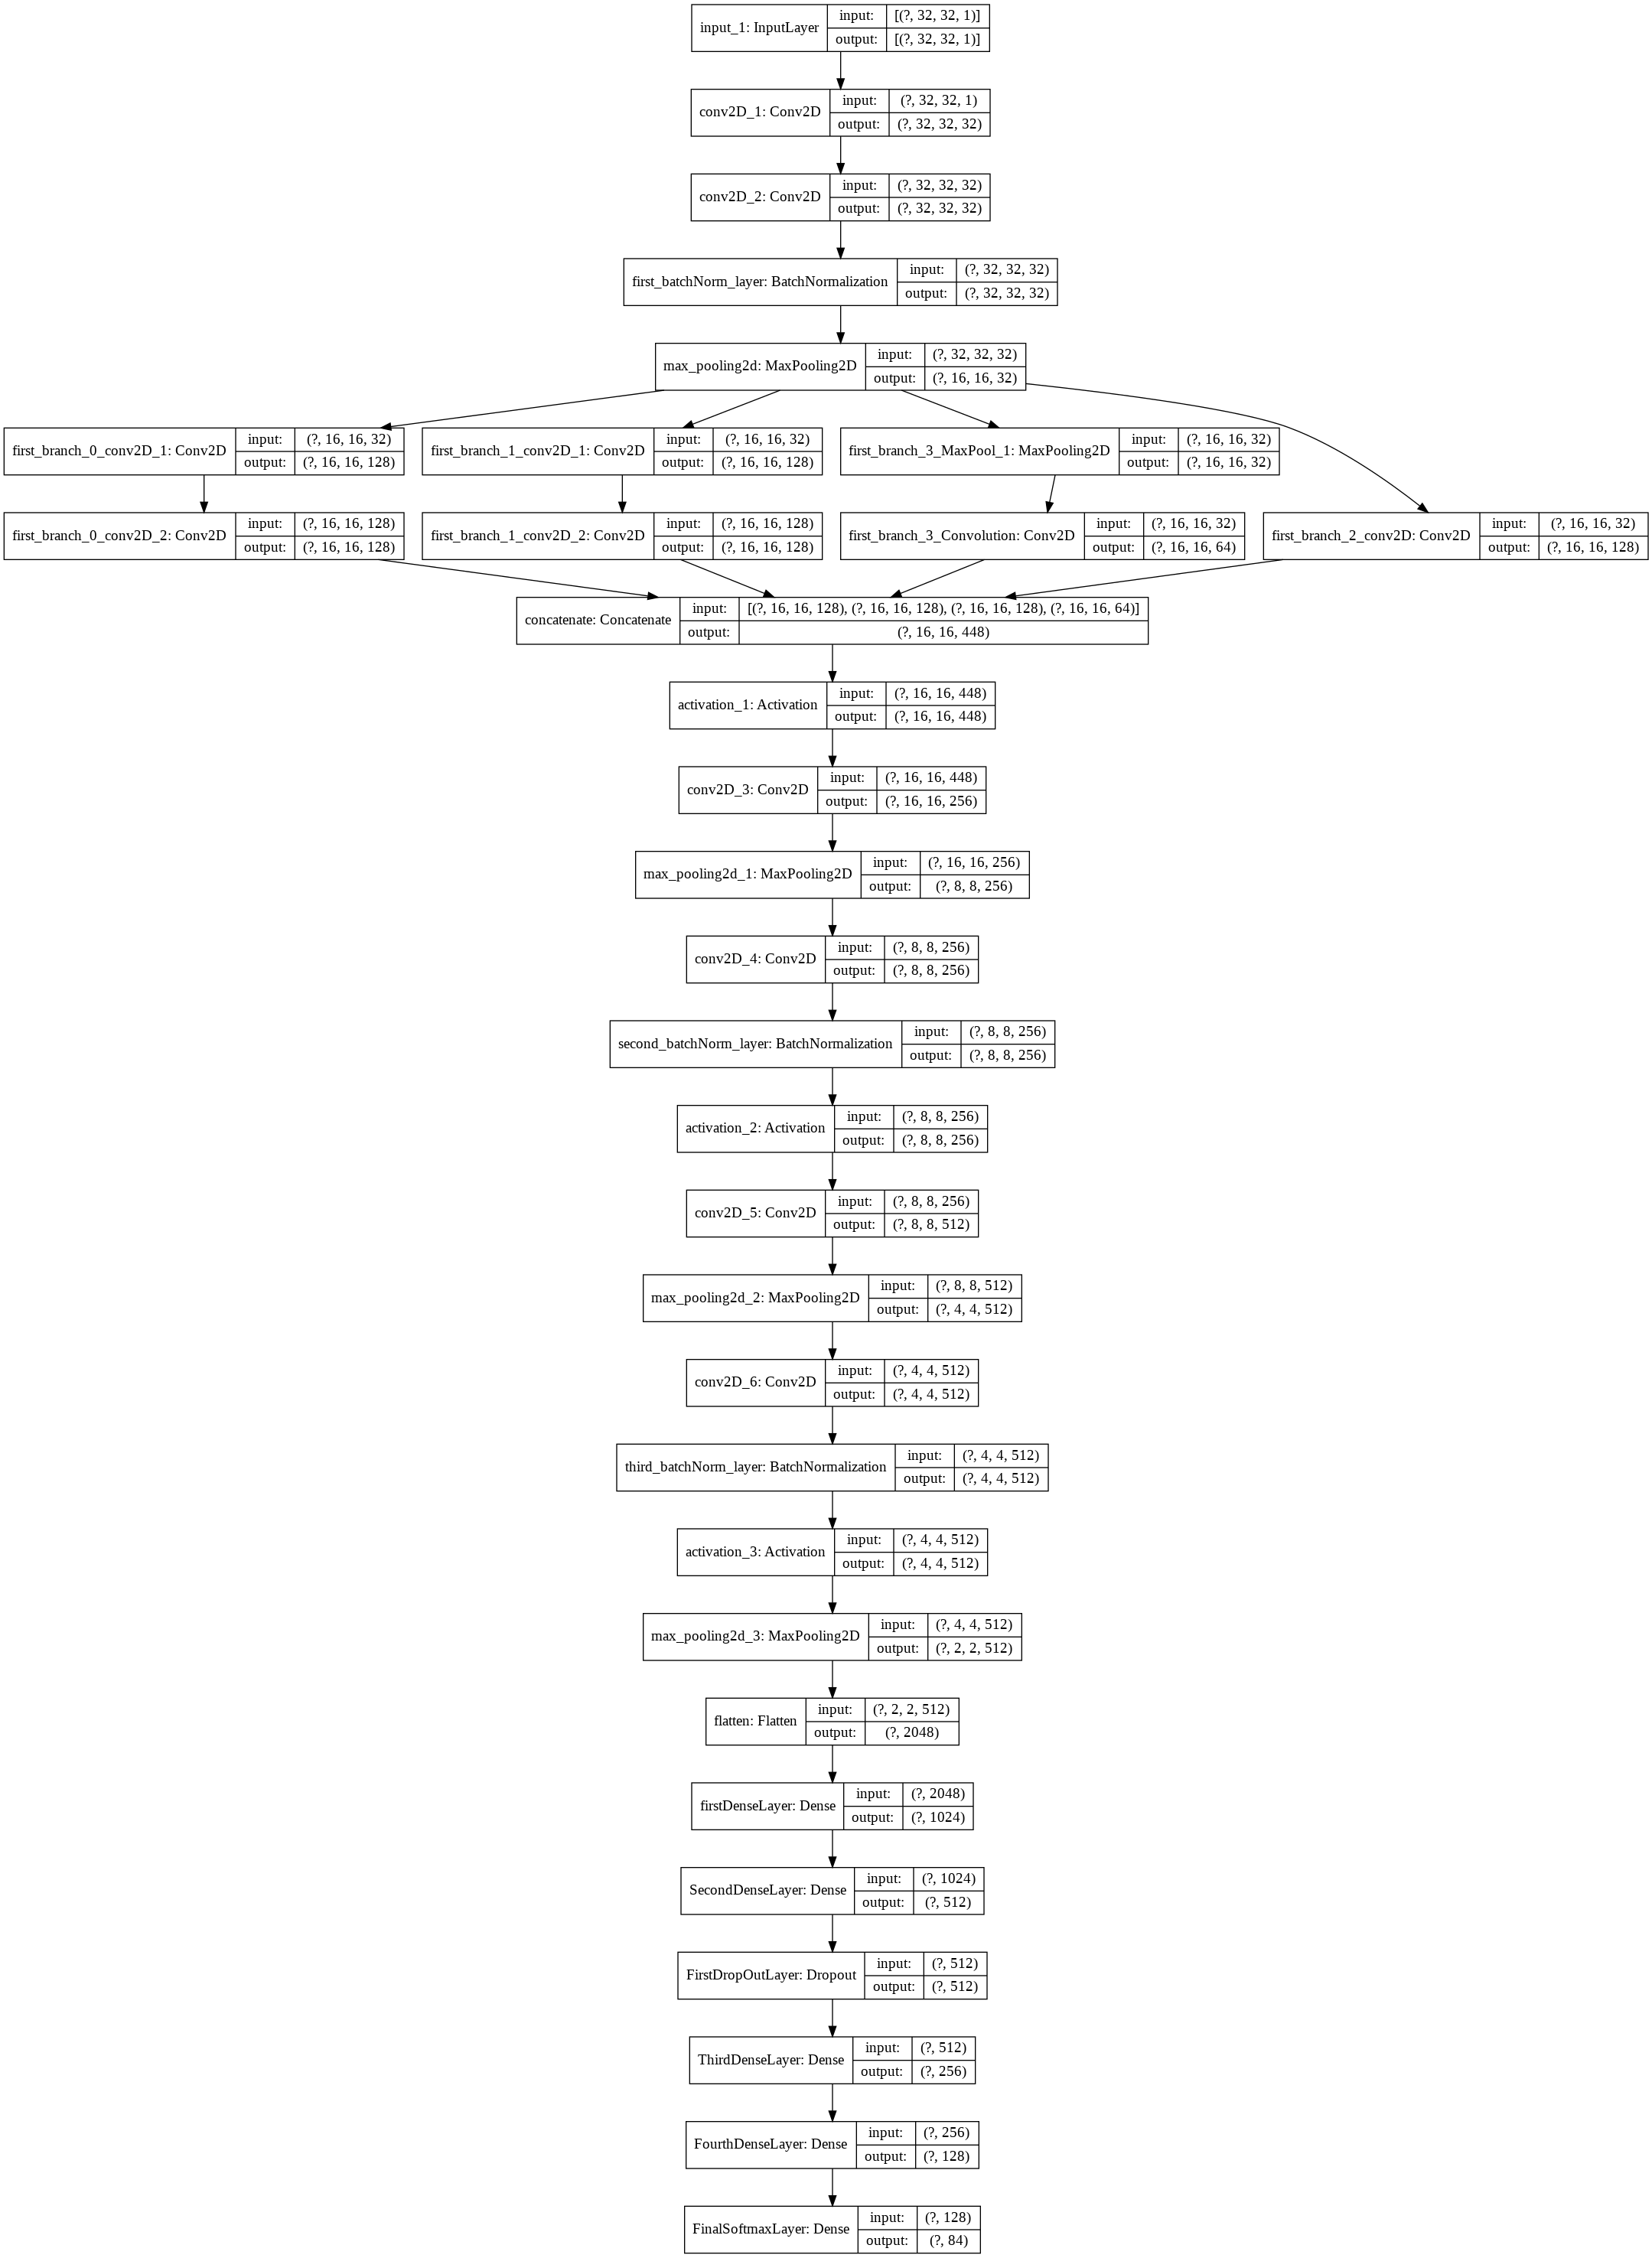

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'AKHCRNetV2.png', show_shapes=True)

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_generator,
                    epochs=5,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // batch_size, callbacks=callbacks_list)

Epoch 1/5
462/462 [==============================] - ETA: 0s - loss: 2.8836 - accuracy: 0.3881
Epoch 00001: val_loss improved from inf to 1.36770, saving model to model.h5
462/462 [==============================] - 133s 288ms/step - loss: 2.8836 - accuracy: 0.3881 - val_loss: 1.3677 - val_accuracy: 0.6384
Epoch 2/5
462/462 [==============================] - ETA: 0s - loss: 0.8584 - accuracy: 0.8167
Epoch 00002: val_loss improved from 1.36770 to 0.44341, saving model to model.h5
462/462 [==============================] - 131s 283ms/step - loss: 0.8584 - accuracy: 0.8167 - val_loss: 0.4434 - val_accuracy: 0.9239
Epoch 3/5
462/462 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.8734
Epoch 00003: val_loss improved from 0.44341 to 0.35326, saving model to model.h5
462/462 [==============================] - 131s 284ms/step - loss: 0.6211 - accuracy: 0.8734 - val_loss: 0.3533 - val_accuracy: 0.9434
Epoch 4/5
462/462 [==============================] - ETA: 0s - loss: 0.

In [ ]:
from keras import backend as K
print(model.optimizer.learning_rate)

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>


Using TensorFlow backend.


In [ ]:
new_model = tf.keras.models.load_model(filepath)
K.set_value(new_model.optimizer.learning_rate, 0.0001)

history = new_model.fit(train_generator,
                    epochs=3,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.samples // batch_size, callbacks=callbacks_list)

Epoch 1/3
462/462 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.9467
Epoch 00001: val_loss improved from 0.30081 to 0.24151, saving model to model.h5
462/462 [==============================] - 131s 284ms/step - loss: 0.3121 - accuracy: 0.9467 - val_loss: 0.2415 - val_accuracy: 0.9661
Epoch 2/3
462/462 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9549
Epoch 00002: val_loss improved from 0.24151 to 0.23421, saving model to model.h5
462/462 [==============================] - 131s 284ms/step - loss: 0.2722 - accuracy: 0.9549 - val_loss: 0.2342 - val_accuracy: 0.9663
Epoch 3/3
462/462 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.9592
Epoch 00003: val_loss improved from 0.23421 to 0.22147, saving model to model.h5
462/462 [==============================] - 131s 284ms/step - loss: 0.2456 - accuracy: 0.9592 - val_loss: 0.2215 - val_accuracy: 0.9679


In [ ]:
new_model2 = tf.keras.models.load_model(filepath)
print(new_model2.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [ ]:
from keras import backend as K
K.set_value(new_model2.optimizer.learning_rate, 0.00004)
print(new_model2.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4e-05>


In [ ]:
history = new_model2.fit(train_generator,
                    epochs=3,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.samples // batch_size, callbacks=callbacks_list)

Epoch 1/3
462/462 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9651
Epoch 00001: val_loss improved from 0.22147 to 0.22001, saving model to model.h5
462/462 [==============================] - 131s 284ms/step - loss: 0.2196 - accuracy: 0.9651 - val_loss: 0.2200 - val_accuracy: 0.9679
Epoch 2/3
462/462 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9668
Epoch 00002: val_loss improved from 0.22001 to 0.21911, saving model to model.h5
462/462 [==============================] - 131s 284ms/step - loss: 0.2105 - accuracy: 0.9668 - val_loss: 0.2191 - val_accuracy: 0.9677
Epoch 3/3
462/462 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9687
Epoch 00003: val_loss improved from 0.21911 to 0.21612, saving model to model.h5
462/462 [==============================] - 131s 284ms/step - loss: 0.2016 - accuracy: 0.9687 - val_loss: 0.2161 - val_accuracy: 0.9680


In [ ]:
new_model3 = tf.keras.models.load_model(filepath)
print(new_model3.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4e-05>


In [57]:
!ls

adc.json		   AKHCRNetV2.png  model.h5
akhcrnetv1dataprivate.zip  Images	   sample_data


In [ ]:
from google.colab import files
files.download('AKHCRNetV2.png')